## Models of electricity demand



In [ ]:
install.packages("tsibble")
install.packages("feasts")
install.packages("fable")
install.packages("urca")
library(dplyr)
library(lubridate)
library(ggplot2)
library(tsibble)
library(feasts)
library(fable)
library(splines)

In [ ]:
DATA <- as_tsibble(readRDS("DATA.rds"))
head(DATA)

Time,Temperature,Demand,Day_of_week,Workday,Saturday,Sunday,Workday_after_nonWork,NonWeekend_holiday
<dttm>,<dbl>,<dbl>,<ord>,<lgl>,<lgl>,<lgl>,"<lgl[,1]>",<lgl>
2016-01-01 00:00:00,-8.731,15066200,Fri,FALSE,FALSE,FALSE,FALSE,TRUE
2016-01-01 01:00:00,-8.784,14486775,Fri,FALSE,FALSE,FALSE,FALSE,TRUE
2016-01-01 02:00:00,-8.797,13841413,Fri,FALSE,FALSE,FALSE,FALSE,TRUE
2016-01-01 03:00:00,-8.851,13375913,Fri,FALSE,FALSE,FALSE,FALSE,TRUE
2016-01-01 04:00:00,-8.904,13163563,Fri,FALSE,FALSE,FALSE,FALSE,TRUE
2016-01-01 05:00:00,-8.939,13132988,Fri,FALSE,FALSE,FALSE,FALSE,TRUE


In [ ]:
train_set <- DATA %>% filter(year(Time) <= 2018)
test_set <- DATA %>% filter(year(Time) > 2018)
train_obs <- nrow(train_set)

,Freq,Per,Spec
,<dbl>,<dbl>,<dbl>
1,0.0416666667,24.00000,1.077319e+17
2,0.0059629630,167.70186,2.839533e+16
3,0.0001111111,9000.00000,2.325462e+16
4,0.0833333333,12.00000,2.211790e+16
5,0.0118888889,84.11215,7.559224e+15
6,0.0059259259,168.75000,5.952089e+15


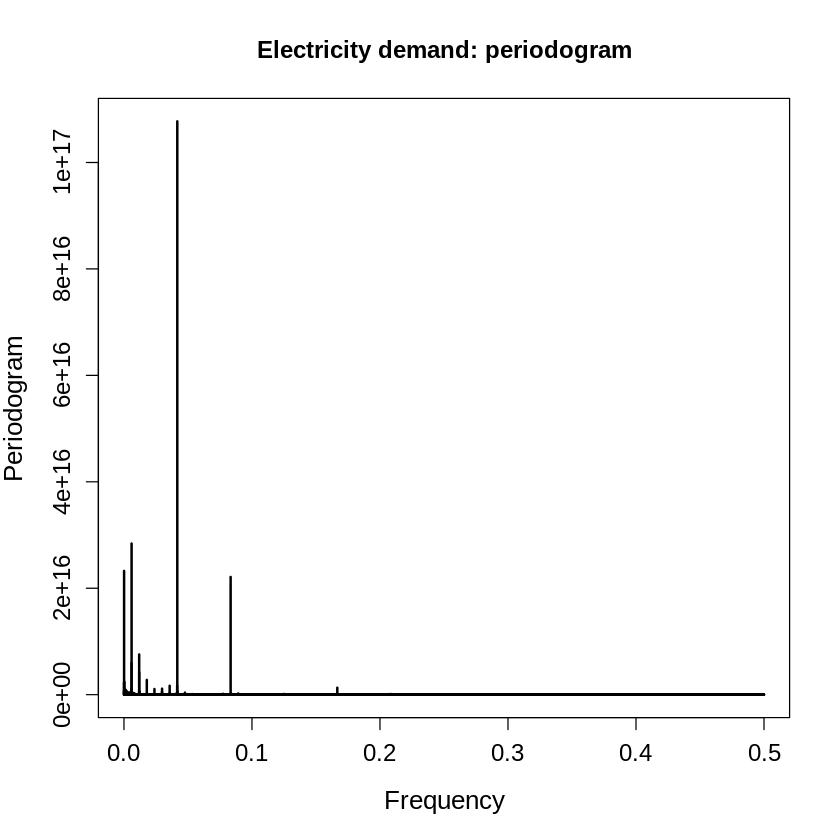

In [ ]:
library(TSA)
p <- periodogram(train_set$Demand, cex.axis=1.2, cex.lab=1.3)
title("Electricity demand: periodogram")
pspec <- as.data.frame(cbind(Freq=p$freq, Per=1/p$freq, Spec=p$spec))
pspec %>% arrange(desc(Spec)) %>% head()

# Estimation

### Some benchmark methods

In [ ]:
# seasonal naive method
snaive1 <- train_set %>% model(SNAIVE(Demand ~ lag("day")))
saveRDS(snaive1, file="snaive1.rds")

In [ ]:
# auto ARIMA
arima1 <- train_set %>% model(ARIMA(Demand))
saveRDS(arima1, file="arima1.rds")

In [ ]:
# exponential smoothing (ETS)
ets1 <- train_set %>% model(ETS(Demand))
saveRDS(ets1, file="ets1.rds")

### RED: dynamic regression with Fourier terms, Workday and ARMA errors

In [ ]:
# RED: dynamic regression with Fourier terms, Workday and ARMA errors
four_year <- seq(1,4)
four_week <- seq(1,7)
four_day <- seq(1,10)
best1 <- matrix(0,0,4)
best2 <- matrix(0,0,4)

# grid search - CAUTION: computationally expensive

# RED1 - daily seasonal ARMA errors + weekly and yearly seasonality as Fourier terms
for (y in 1:length(four_year)){
  for (w in 1:length(four_week)){

      RED1 <- train_set %>% model(ARIMA(log1p(Demand) ~ pdq(d = 0) + PDQ(0, 1, 1, period=24) + Workday +
                             fourier(period = "week", K = four_week[w]) +
                             fourier(period = "year", K = four_year[y])))
      best1 <- rbind(best1,cbind(d,w,y,glance(RED1)[,"AIC"]))
  }
}

# RED2 - non-seasonal ARMA errors and 3 seasonal components as Fourier terms
for (y in 1:length(four_year)){
  for (w in 1:length(four_week)){
    for (d in 1:length(four_day)){
      RED2 <- train_set %>% model(ARIMA(log1p(Demand) ~ pdq(d = 0) + PDQ(0, 0, 0) + Workday +
                             fourier(period = "day", K = four_day[d]) +
                             fourier(period = "week", K = four_week[w]) +
                             fourier(period = "year", K = four_year[y])))
      best2 <- rbind(best2,cbind(d,w,y,glance(RED2)[,"AIC"]))
    }
  }
}

Better results achieved with model where only weekly and yearly seasonality is modeled by Fourier terms and daily seasonality is modeled by seasonal ARIMA error

In [ ]:
RED1 <- train_set %>% model(ARIMA(log1p(Demand) ~ pdq(1,0,4) + PDQ(0,1,1,period=24) +
                    Workday +
                    fourier(period = "week", K = 6) +
                    fourier(period = "year", K = 3)))
RED2 %>% refit(test_set) %>% accuracy() %>% select(RMSE,MAPE)

RMSE,MAPE
<dbl>,<dbl>
212205.7,0.7723817


In [ ]:
RED2 <- train_set %>% model(ARIMA(log1p(Demand) ~ pdq(d = 0) + PDQ(0, 0, 0) + Workday +
                    fourier(period = "day", K = 9) +
                    fourier(period = "week", K = 6) +
                    fourier(period = "year", K = 3)))
RED %>% refit(test_set) %>% accuracy() %>% select(RMSE,MAPE)

RMSE,MAPE
<dbl>,<dbl>
388207.9,1.497924


### SPRED: introducing temperature effect with interactions

This model offers only a tiny improvement when it comes to 1h forecasting horizon.

In [ ]:
SPRED <- train_set %>% model(ARIMA(log1p(Demand) ~ pdq(1,0,4) + PDQ(0,1,1,period=24) +
                    NonWeekend_holiday + Temperature + pmax(Temperature, 16) +
                    NonWeekend_holiday*Temperature + NonWeekend_holiday*pmax(Temperature,16)+
                    fourier(period = "week", K = 6) +
                    fourier(period = "year", K = 3)))
saveRDS(SPRED3,"SPRED3.rds")
SPRED %>% refit(test_set) %>% accuracy() %>% select(RMSE,MAPE)

RMSE,MAPE
<dbl>,<dbl>
211914.8,0.7714787


### Prophet

In [ ]:
# original prophet model
install.packages('prophet')

In [ ]:
library(prophet)
df <- train_set[,c("Time","Demand")]
colnames(df) <- c("ds", "y")

Loading required package: Rcpp

Loading required package: rlang



In [ ]:
# raw prophet
m <- prophet(df)

In [ ]:
# prophet with holiday effect
m <- prophet()
m <- add_country_holidays(m, country_name = "PL")       # built-in PL holidays
m <- fit.prophet(m, df)

In [ ]:
m$train.holiday.names

[1] "Nowy Rok"                              
 [2] "Swieto Trzech Kroli"                   
 [3] "Niedziela Wielkanocna"                 
 [4] "Poniedziaek Wielkanocny"               
 [5] "Swieto Panstwowe"                      
 [6] "Swieto Narodowe Trzeciego Maja"        
 [7] "Zielone Swiatki"                       
 [8] "Dzien Bozego Ciaa"                     
 [9] "Wniebowziecie Najswietszej Marii Panny"
[10] "Uroczystosc Wszystkich swietych"       
[11] "Narodowe Swieto Niepodlegosci"         
[12] "Boze Narodzenie (pierwszy dzien)"      
[13] "Boze Narodzenie (drugi dzien)"

In [ ]:
future <- make_future_dataframe(m, periods = 24*365, freq = 60*60)
tail(future)

,ds
,<dttm>
35059,2019-12-31 18:00:00
35060,2019-12-31 19:00:00
35061,2019-12-31 20:00:00
35062,2019-12-31 21:00:00
35063,2019-12-31 22:00:00
35064,2019-12-31 23:00:00


In [ ]:
forecast <- predict(m, future)
tail(forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')])

,ds,yhat,yhat_lower,yhat_upper
,<dttm>,<dbl>,<dbl>,<dbl>
35059,2019-12-31 18:00:00,23227430,12127719,34873980
35060,2019-12-31 19:00:00,23192966,11898519,34835555
35061,2019-12-31 20:00:00,22468889,11428153,34586829
35062,2019-12-31 21:00:00,21198294,9836663,32983937
35063,2019-12-31 22:00:00,19822067,8668972,31896636
35064,2019-12-31 23:00:00,18730405,7600170,30397503


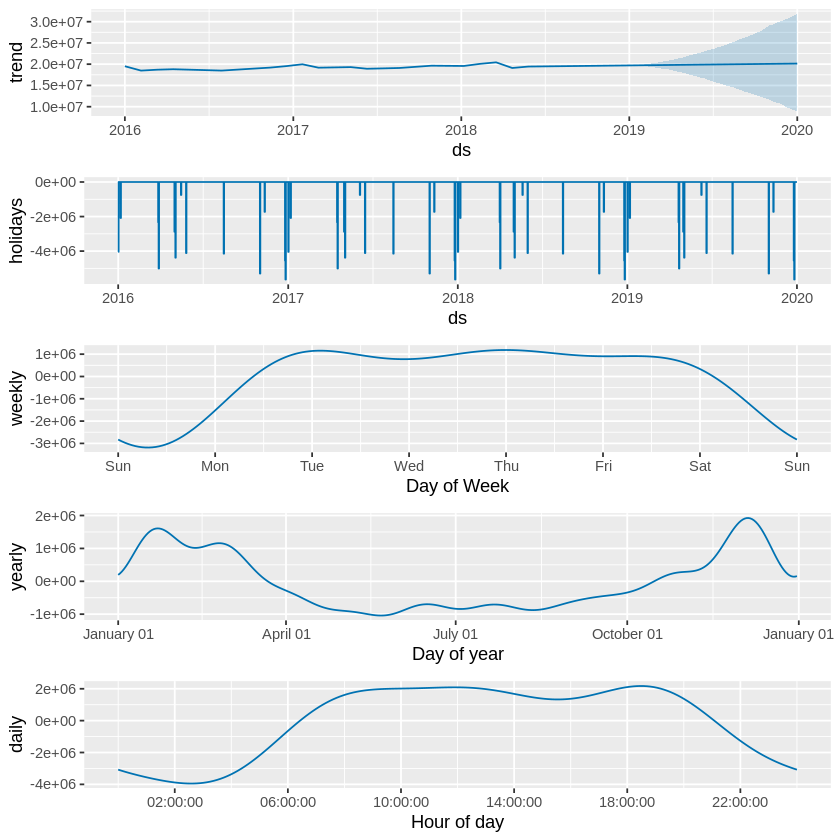

In [ ]:
prophet_plot_components(m, forecast, weekly_start = 2)

In [ ]:
# prophet with both temperature & holiday effect
df[,"temperature"] <- train_set[,"Temperature"]

m1 <- prophet()
m1 <- add_country_holidays(m1, country_name = "PL")       # built-in PL holidays
m1 <- add_regressor(m1, "temperature")
m1 <- fit.prophet(m1, df)

future1 <- make_future_dataframe(m1, periods = 24*365, freq = 60*60)
future1[,"temperature"] <- DATA[,"Temperature"]

forecast2 <- predict(m1, future1)

In [ ]:
saveRDS(forecast2,"prophet_forecast1step.rds")

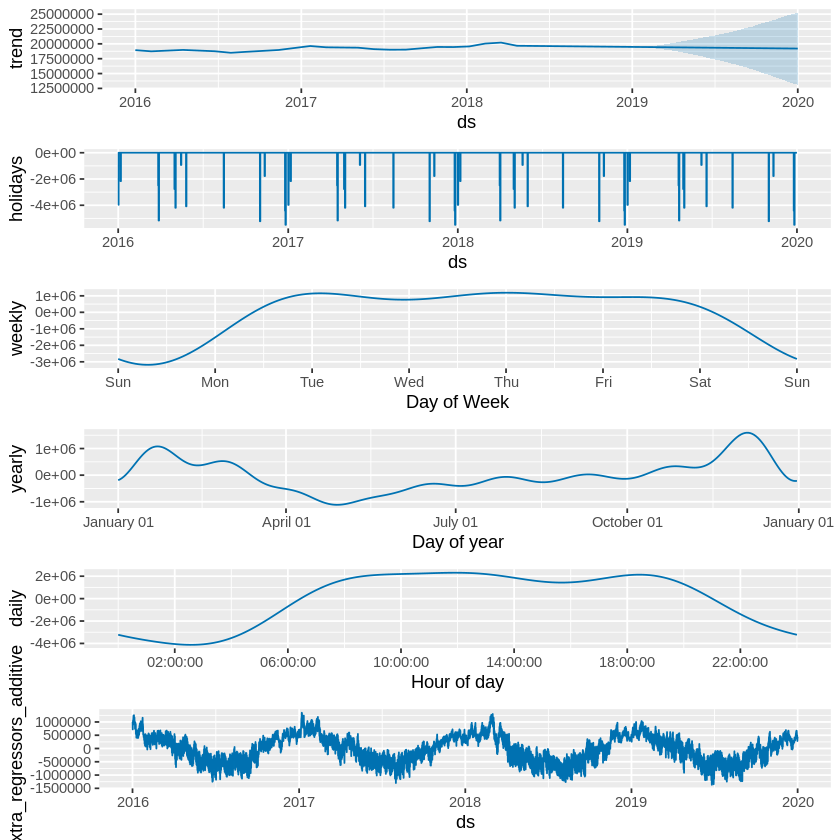

In [ ]:
prophet_plot_components(m1, forecast2, weekly_start = 2)

In [ ]:
cv <- cross_validation(m1, initial = 365*2*24, period = 750, horizon = 24, units = 'hours')
head(cv)

Making 12 forecasts with cutoffs between 2018-01-21 05:00:00 and 2018-12-30 23:00:00



y,ds,yhat,yhat_lower,yhat_upper,cutoff
<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dttm>
16362550,2018-01-21 06:00:00,17532043,16113353,18787559,2018-01-21 05:00:00
16726013,2018-01-21 07:00:00,18942110,17658480,20171668,2018-01-21 05:00:00
17524575,2018-01-21 08:00:00,19830186,18522678,21122957,2018-01-21 05:00:00
18579275,2018-01-21 09:00:00,20198607,18936262,21381435,2018-01-21 05:00:00
19270813,2018-01-21 10:00:00,20300898,19061027,21537134,2018-01-21 05:00:00
19456100,2018-01-21 11:00:00,20383876,19174018,21665040,2018-01-21 05:00:00


In [ ]:
cv_result <- performance_metrics(cv)
cv_result

horizon,mse,rmse,mae,mape,mdape,smape,coverage
<drtn>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3 hours,9.291715e+11,963935.4,784481.7,0.04158463,0.03657685,0.04101676,0.8333333
4 hours,8.117326e+11,900962.1,726633.7,0.03882233,0.03657685,0.03840172,0.8571429
5 hours,8.251477e+11,908376.4,724130.1,0.03902240,0.03018517,0.03886525,0.7738095
6 hours,1.102801e+12,1050143.2,826331.2,0.04476197,0.04378358,0.04463008,0.6904762
7 hours,1.419642e+12,1191487.1,925622.1,0.05013187,0.04457187,0.04968166,0.7023810
8 hours,1.629596e+12,1276556.2,942149.7,0.05096826,0.03388744,0.04997902,0.7023810
9 hours,1.699500e+12,1303648.7,919656.6,0.04993355,0.02902310,0.04863768,0.7500000
10 hours,1.604546e+12,1266706.6,873593.6,0.04773915,0.02902310,0.04657705,0.8095238
11 hours,1.356459e+12,1164671.3,782970.9,0.04285220,0.02477567,0.04189407,0.8333333


In [ ]:
cv <- cross_validation(m1, initial = 365*2*24, period = 200, horizon = 1, units = 'hours')

Making 12 forecasts with cutoffs between 2018-01-22 04:00:00 and 2018-12-31 22:00:00



In [ ]:
performance_metrics(cv)

horizon,mse,rmse,mae,mape,mdape,smape,coverage
<drtn>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1 hours,1.600196e+12,1264989,950860,0.05387804,0.04680311,0.05190385,0.75
